# Double pendulum problem

A double pendulum is described in the configuration space by the equations:


In [1]:
from scipy.integrate import solve_ivp
import pandas as pd
import numpy as np
#Libraries for the rendering
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, clear_output, HTML

## Utilities

In [2]:
# Map to convert any angle to the range 0-2pi
def map_to_2pi(alpha):
  k = np.floor(alpha/(2*np.pi)) #Number of complete rotations
  alpha = alpha-k*2*np.pi
  return alpha

# Plot the pendulum
def plot_trajectory(data_frames, t_span=None, color='g'):
  data_frames = (lambda x: x if type(x) is tuple else (x,))(data_frames)  #If the input is a single element make it a tuple, else, execute normally
  fig, ax = plt.subplots()
  max = []
  for df in data_frames:
    max.append(1.1*np.abs(df['y']).max()) #Find the maximum distance from the origin 
    
  fig.suptitle('Double pendulum')
      
  max = np.array(max).max() 
  
  ax.set_xlim(-max, max)
  ax.set_ylim(-max, max)
  ax.set_aspect('equal')
  ax.grid()
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  if t_span != None:
    ax.text(0.05,0.9, f't = {t_span[1]:.2f}', transform = ax.transAxes)
  
  for df in data_frames:
    if t_span != None:
      df = df[(df['t'] >= t_span[0]) & (df['t'] <= t_span[1])]
    
    ax.plot(df['x'], df['y'])
    ax.plot([0, df.iloc[-1][ 'x']], [0, df.iloc[-1][ 'y']], 'r-o')
  plt.show()

## Lagrangian of the pendulum

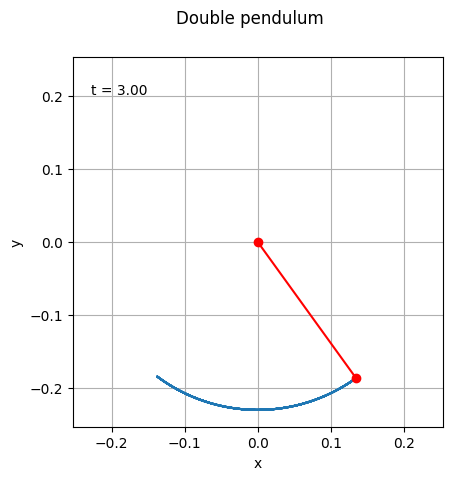

,t,theta,v_theta,K,U,E,x,y
0,0.000000,2.500000,0.000000,0.000000,-1.807620,-1.80762,0.137649,-0.184263
1,0.005005,2.500320,0.127740,0.000432,-1.808052,-1.80762,0.137590,-0.184307
2,0.010010,2.501278,0.255371,0.001725,-1.809345,-1.80762,0.137413,-0.184439
3,0.015015,2.502876,0.382783,0.003876,-1.811496,-1.80762,0.137118,-0.184658


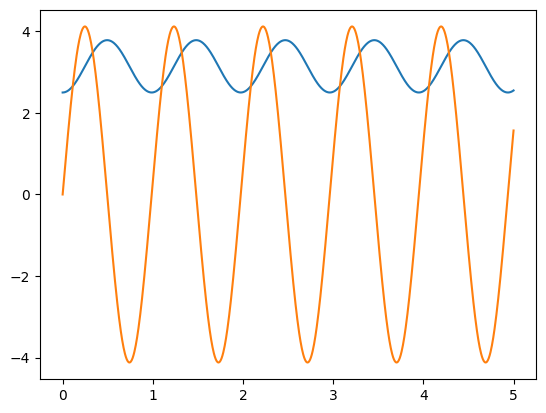

In [3]:
# dy/dt = f(t,y), with y = (theta, dtheta/dt)

def f(t, y, g, r):
  return(y[1], g/r*np.sin(y[0]))

g = 9.81
r = 0.5
m = 0.1

def pendulum_df(y0, t_span, m, g, r, n_points=1000):  
  
  Y = solve_ivp(f, t_span=t_span, y0=y0 , method='RK45', args=(g,r), t_eval=np.linspace(t_span[0],t_span[1], n_points), rtol=1e-6)
  pendulum_df = pd.DataFrame({'t':Y.t, 'theta': map_to_2pi(Y.y[0]), 'v_theta': Y.y[1]})
  pendulum_df['K'] = 0.5*m*(r*pendulum_df['v_theta'])**2
  pendulum_df['U'] = g*m*r*np.cos(pendulum_df['theta'])
  pendulum_df['E'] = pendulum_df['K']+ pendulum_df['U']

  pendulum_df['x'] = r*np.sin(pendulum_df['theta'])
  pendulum_df['y'] = r*np.cos(pendulum_df['theta'])
  return pendulum_df

a = pendulum_df(y0=(2.5, 0.0), t_span=(0,5.0), m=1, g=9.81, r=0.23)
b = pendulum_df(y0=(0.3,0.0), t_span=(0,5.0), m=1, g=9.81, r=0.1)

plot_trajectory(a, t_span=(0,3.0))
plt.plot(a['t'], a['theta'])
plt.plot(a['t'], a['v_theta'])
a.head(4)

In [4]:
def animate(i, dt_per_frame):
  t = i*dt_per_frame
  plot_trajectory((a,b), t_span=(t-2,t))

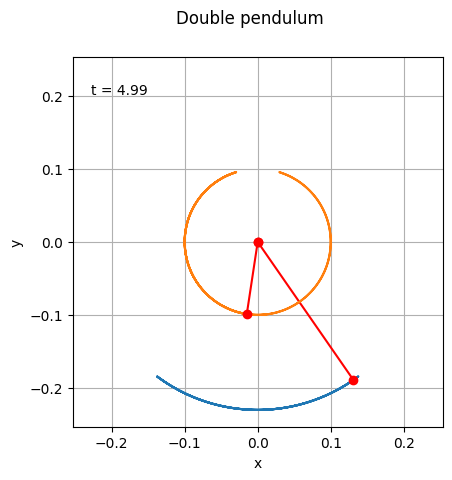

In [5]:
n_frames = 500

for i in range(n_frames):
    clear_output(wait=True)
    animate(i, 0.01)    
    

In [10]:
def create_plot(data_frames, color='g'):
  data_frames = (lambda x: x if type(x) is tuple else (x,))(data_frames)  #If the input is a single element make it a tuple, else, execute normally
  fig, ax = plt.subplots()
  max = []
  for df in data_frames:
    max.append(1.1*np.abs(df['y']).max()) #Find the maximum distance from the origin 
    
  fig.suptitle('Double pendulum')      
  max = np.array(max).max() 
  
  ax.set_xlim(-max, max)
  ax.set_ylim(-max, max)
  ax.set_aspect('equal')
  ax.grid()
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  time = ax.text(0.05,0.9,'', transform = ax.transAxes)
  #NB: both traces and markers are memorized as an array of arrays containing the single element
  traces = [ax.plot(0,0, linestyle = '-', alpha=0.5) for df in data_frames]
  markers = [ax.plot(0,0, c = trace[0].get_color(), linestyle = ':', marker = 'o') for trace in traces]
  plt.close('all')
  return fig, [traces, markers, time]

#Plots the figure by updating the objects inside
def plot_figure(data_frames, t_span=None):
  fig, artists = create_plot(data_frames)
  traces, markers, time = artists[0], artists[1], artists[2]    
  
  if t_span != None:
    time.set_text(f't = {t_span[1]:.2f}')
    for df in data_frames: df = df[(df['t'] >= t_span[0]) & (df['t'] <= t_span[1])]

  for trace, df in zip(traces, data_frames): trace[0].set_data(df['x'], df['y']) 
  for marker, df in zip(markers, data_frames): marker[0].set_data([0, df.iloc[-1][ 'x']], [0, df.iloc[-1][ 'y']])   
  display(fig)
  
def animate_RT(frames):
  fig, artists = create_plot()
  
  
  for i in range(frames):
    update(i, frames, artists)
    display(fig)
    clear_output(wait=True)  
    
def update(i, frames, artists):
  for df in data_frames:
    if t_span != None:
      df = df[(df['t'] >= t_span[0]) & (df['t'] <= t_span[1])]
    
    ax.plot(df['x'], df['y'])
    ax.plot([0, df.iloc[-1][ 'x']], [0, df.iloc[-1][ 'y']], 'r-o') 
    
def animate_HTML(duration):
  fig, artists = create_plot()
  fps = 10
  n_frames = round(duration*fps) #total of frames to be drawn
  ani = animation.FuncAnimation(fig, update, n_frames, fargs = (n_frames, artists), interval = 1000.0/fps)
  return ani

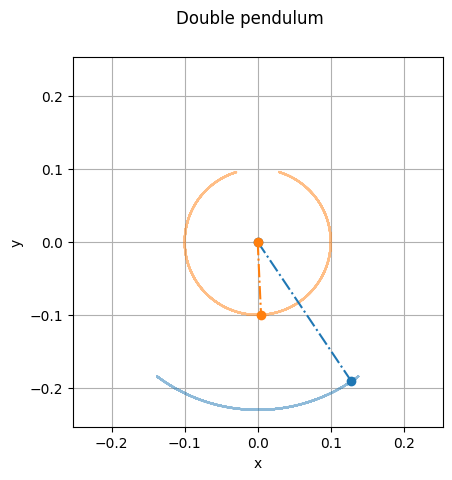

In [11]:
plot_figure((a,b))